<a href="https://colab.research.google.com/github/ben900926/Plant-seedling-classification/blob/main/AI_final_project_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
import os
import cv2
from sklearn import preprocessing # for data preprocess, e.g label encoding
from sklearn.model_selection import train_test_split # for splitting train data for validation
# for convolutional
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import Flatten, GlobalAveragePooling2D, Average
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization, ZeroPadding2D, Activation
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from sklearn.metrics import confusion_matrix
# convolution end
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
scale = 70 # Alexnet : 227 -> 224
seed = 7
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed',
 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']

In [ ]:
class Image_dataset:

    def __init__(self):
        self.train_set = list()
        self.original_labels = list()
        self.train_labels = list() # store files address for testing
        self.x_train = []
        self.x_val = []
        self.y_train = []
        self.y_val = []

    # load training sets from image files
    def load_train_file(self,path,saved_path,dirs=None):
        if dirs is None: # want all datas
          dirs = os.listdir(path) # read images from given file
        for dir in dirs:
            count = 0
            for img in os.listdir(os.path.join(path,dir)):
                img = os.path.join(path,dir,img)
                self.train_set.append(cv2.resize(cv2.imread(img),(scale,scale)))
                self.train_labels.append(dir)
                count += 1
            print(f"{dir}: load {count} images done!")
        self.train_set = np.asarray(self.train_set)
        print('\n')
        print('Orignal xtrain shape : {}'.format(self.train_set.shape)) #(4750, dim, dim, 3)
        # save original file
        np.savez(saved_path,
               train_set=self.train_set,train_labels=self.train_labels)
        # panda data
        self.train_labels = pd.DataFrame(self.train_labels)
    
    # load testing sets from single directory
    def load_test_file(self,path, saved_path):
      dir = os.listdir(path)
      count = 0
      for img in dir:
        self.train_labels.append(img)
        img = os.path.join(path,img)
        self.train_set.append(cv2.resize(cv2.imread(img),(scale,scale)))
        count += 1
      print(f"load {count} images done!")
      self.train_set = np.asarray(self.train_set)
      self.train_labels = np.asarray(self.train_labels)
      print('\n')
      print('Test xtrain shape : {}'.format(self.train_set.shape))
      # save the datasets
      np.savez(saved_path,
               train_set=self.train_set,train_labels=self.train_labels)
    
    # convert image to hsv, remove background and noise
    def clean_img(self):
        new_train = []
        for i in self.train_set:
            blurr = cv2.GaussianBlur(i,(5,5),0)
            hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV) # BGR to HSV : easier to filter
            # define the range of green color in HSV
            lower = (25,40,50)
            upper = (75,255,255)
            mask = cv2.inRange(hsv,lower,upper) # only show green
            # morphology : eliminate noise
            struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
            mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc) # morph_close : remove black holes 
            boolean = mask>0
            new = np.zeros_like(i,np.uint8)
            new[boolean] = i[boolean]
            new_train.append(new)
        self.train_set = np.asarray(new_train)
    
    # use sklearn to do label encoding to fit numerical computation
    def label_encoding(self):
        labels = preprocessing.LabelEncoder()
        labels.fit(self.train_labels[0]) # collect label from the datasets of images
        self.original_labels = labels
        # tranform label into binary format
        encoded_label = labels.transform(self.train_labels[0])
        print('\n')
        print('Classes'+str(labels.classes_))
        species = str(labels.classes_)
        binary_label = np_utils.to_categorical(encoded_label)
        self.train_labels = binary_label    

    # split the train data to prevent overfitting
    def split_data(self,saved_path):
      # normalization
      self.train_set = self.train_set/255
      self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.train_set, self.train_labels, test_size=0.1, random_state=seed, stratify=self.train_labels)
      print('\n---Split training and validation sets---')
      print('xtrain shape : {}'.format(self.x_train.shape))
      print('ytrain shape : {}'.format(self.y_train.shape))
      print('  xval shape : {}'.format(self.x_val.shape))
      print('  yval shape : {}'.format(self.y_val.shape))
      print('----------------------------------------------')
      # save the datasets
      np.savez(saved_path,
               train_set=self.train_set,train_labels=self.train_labels,x_train=self.x_train,x_val=self.x_val,y_train=self.y_train,y_val=self.y_val)


In [ ]:
import itertools
# plot loss acc curves
def plot_loss_acc_curves(history):
    """Plot the loss and accuracy curves for training and validation data"""
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    plt.show()

# plot labeled confusion matrix
def plot_confusion_matrix(cm, classes,normalize=False,cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.matshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
model_input = Input(shape=(scale,scale,3))
class convolutional_network:

  def __init__(self, epoches, batch_size, load_path):
    dataset = np.load(load_path) # load dataset from file
    self.train_set = dataset['train_set']
    self.train_labels = dataset['train_labels']
    self.x_train = dataset['x_train']
    print(self.x_train[0,:,:,:].shape)
    self.x_val = dataset['x_val']
    self.y_train = dataset['y_train']
    self.y_val = dataset['y_val']
    #self.datagen = None
    # for training
    self.epoches = epoches
    self.batch_size = batch_size
    # define neural network
    self.model = Sequential()

  # ensemble CNN https://towardsdatascience.com/ensembling-convnets-using-keras-237d429157eb
  # first model : Conv-pool-C
  def conv_pool(self):
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(len(species), (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='conv_pool_cnn')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    self.model = model

  # second model : all-cnn, similar to first one, but maxpool replaced by conv2d
  def all_cnn(self):
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(len(species), (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
        
    model = Model(model_input, x, name='all_cnn')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    self.model = model

  # third model: network cnn
  def nin_cnn(self):
    #mlpconv block 1
    x = Conv2D(32, (5, 5), activation='relu',padding='valid')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.5)(x)
    
    #mlpconv block2
    x = Conv2D(64, (3, 3), activation='relu',padding='valid')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.5)(x)
    
    #mlpconv block3
    x = Conv2D(128, (3, 3), activation='relu',padding='valid')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(len(species), (1, 1))(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='softmax')(x)
    
    model = Model(model_input, x, name='nin_cnn')
    self.model = model
  # ensemble models
  def ensemble(self, model_inputs):
    o = [model.outputs[0] for model in model_inputs]
    y = Average()(o)
    model = Model(inputs=model_input,outputs=y)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    self.model = model


  # train the model for given epoches
  def fit(self,save_best_path,preload=None):
    # prevent overfitting
    # ImageDataGenerator() : data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True, # randomly flip images
        )
    print('xtrain shape : {}'.format(self.x_train.shape))
    datagen.fit(self.x_train)
    
    # reduce the learning rate by 0.5
    lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.4, patience=6, verbose=1, min_lr=0.00001)
    # save the best considered model with epoch number and validation accuracy
    checkpoints = ModelCheckpoint(save_best_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    # train model with batch
    print("batch size:{}".format(self.x_train.shape[0]))
    # step_per_epoch * batch_size = len(train_data)


    if preload is not None:
      self.model.load_weights(preload)

    train_model = self.model.fit_generator( datagen.flow(self.x_train,self.y_train,batch_size=self.batch_size)
                                 ,epochs=self.epoches
                                 ,validation_data=(self.x_val,self.y_val)
                                ,steps_per_epoch=self.x_train.shape[0]/self.batch_size # batch size
                                 #,validation_steps=len(self.x_val)
                                 ,callbacks=[checkpoints, lrr])# checkpoints_full])
    # plot graphs
    plot_loss_acc_curves(train_model)
    
  # evalutate the model performance
  def evaluate_model(self, load_path=None):
    # load the best model
    if load_path is not None:
      self.model.load_weights(load_path)
    # print evaluation
    print(self.model.evaluate(self.x_train,self.y_train))
    print(self.model.evaluate(self.x_val,self.y_val))
    # use confusion matrix to evaluate the prediction
    Y_true = np.argmax(self.y_val, axis=1) # ground truth
    Y_pred = self.model.predict(self.x_val) # prediction
    Y_pred_class = np.argmax(Y_pred, axis=1) # predict the class
    cmatrix = confusion_matrix(Y_true, Y_pred_class)
    plot_confusion_matrix(cmatrix,species)

    

In [ ]:
if __name__ == "__main__":
    train = Image_dataset()
    train.load_train_file('/content/drive/MyDrive/AI_final/train','/content/drive/MyDrive/AI_final/plant_train_dataset2.npz')
    dataset = np.load('/content/drive/MyDrive/AI_final/plant_train_dataset2.npz') # load dataset from file
    train.train_set = dataset['train_set']
    train.train_labels = pd.DataFrame(dataset['train_labels'])
    train.clean_img()
    train.label_encoding()
    train.split_data('/content/drive/MyDrive/AI_final/plant_split_dataset2.npz')

Sugar beet: load 385 images done!
Small-flowered Cranesbill: load 496 images done!
Maize: load 221 images done!
Shepherds Purse: load 231 images done!
Loose Silky-bent: load 654 images done!
Fat Hen: load 475 images done!
Cleavers: load 287 images done!
Scentless Mayweed: load 516 images done!
Common wheat: load 221 images done!
Common Chickweed: load 611 images done!
Charlock: load 390 images done!
Black-grass: load 263 images done!


Orignal xtrain shape : (4750, 70, 70, 3)


Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']

---Split training and validation sets---
xtrain shape : (4275, 70, 70, 3)
ytrain shape : (4275, 12)
  xval shape : (475, 70, 70, 3)
  yval shape : (475, 12)
----------------------------------------------


In [ ]:
    
    conv_model = convolutional_network(epoches=80,batch_size=32,load_path='/content/drive/MyDrive/AI_final/plant_split_dataset2.npz')
    conv_model.conv_pool()
    all_model = convolutional_network(epoches=80,batch_size=32,load_path='/content/drive/MyDrive/AI_final/plant_split_dataset2.npz')
    all_model.all_cnn()
    nin_model = convolutional_network(epoches=80,batch_size=32,load_path='/content/drive/MyDrive/AI_final/plant_split_dataset2.npz')
    nin_model.nin_cnn()
    

(70, 70, 3)
(70, 70, 3)
(70, 70, 3)


xtrain shape : (4275, 70, 70, 3)
batch size:4275


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/80
134/133 [==============================] - ETA: 0s - loss: 2.1582 - accuracy: 0.2395
Epoch 1: val_accuracy improved from -inf to 0.28632, saving model to drive/MyDrive/AI_final/weights.best_conv_01-0.29.hdf5
133/133 [==============================] - 15s 87ms/step - loss: 2.1582 - accuracy: 0.2395 - val_loss: 1.8819 - val_accuracy: 0.2863 - lr: 0.0010
Epoch 2/80
134/133 [==============================] - ETA: 0s - loss: 1.8993 - accuracy: 0.3076
Epoch 2: val_accuracy improved from 0.28632 to 0.29053, saving model to drive/MyDrive/AI_final/weights.best_conv_02-0.29.hdf5
133/133 [==============================] - 10s 75ms/step - loss: 1.8993 - accuracy: 0.3076 - val_loss: 1.8215 - val_accuracy: 0.2905 - lr: 0.0010
Epoch 3/80
134/133 [==============================] - ETA: 0s - loss: 1.7917 - accuracy: 0.3525
Epoch 3: val_accuracy improved from 0.29053 to 0.42526, saving model to drive/MyDrive/AI_final/weights.best_conv_03-0.43.hdf5
133/133 [==============================] - 11

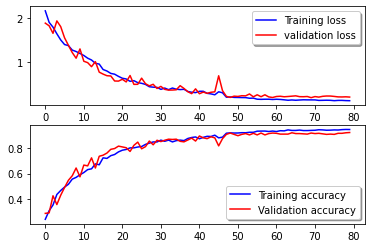

In [ ]:
    # train for a long time!
    conv_model.fit("drive/MyDrive/AI_final/weights.best_conv_{epoch:02d}-{val_accuracy:.2f}.hdf5")

In [ ]:
    all_model.fit("drive/MyDrive/AI_final/weights.best_all_{epoch:02d}-{val_accuracy:.2f}.hdf5")

In [ ]:
    nin_model.fit("drive/MyDrive/AI_final/weights.best_nin_{epoch:02d}-{val_accuracy:.2f}.hdf5")

134/134 [==============================] - 4s 28ms/step - loss: 0.1306 - accuracy: 0.9481
[0.1306420862674713, 0.9480701684951782]
15/15 [==============================] - 0s 27ms/step - loss: 0.2194 - accuracy: 0.9242
[0.2193947434425354, 0.9242105484008789]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


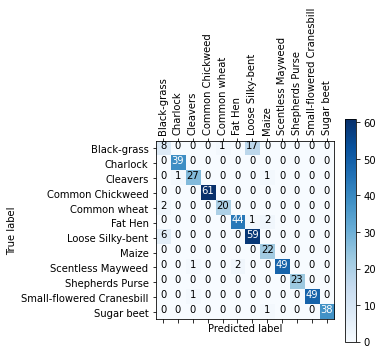

In [ ]:
    conv_model.evaluate_model(load_path='/content/drive/MyDrive/AI_final/weights.best_conv_80-0.92.hdf5')

(70, 70, 3)
134/134 [==============================] - 9s 53ms/step - loss: 0.1786 - accuracy: 0.9488
[0.1785849630832672, 0.9487719535827637]
15/15 [==============================] - 1s 83ms/step - loss: 0.2593 - accuracy: 0.9200
[0.2593466639518738, 0.9200000166893005]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


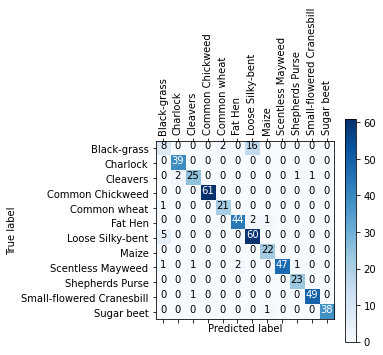

In [ ]:
    conv_model.model.load_weights('/content/drive/MyDrive/AI_final/weights.best_conv_71-0.92.hdf5')
    all_model.model.load_weights('/content/drive/MyDrive/AI_final/weights.best_all_62-0.91.hdf5')
    nin_model.model.load_weights('/content/drive/MyDrive/AI_final/weights.best_nin_65-0.80.hdf5')

    model_inputs = [conv_model.model, all_model.model, nin_model.model]
    ensemble_model = convolutional_network(epoches=80,batch_size=32,load_path='/content/drive/MyDrive/AI_final/plant_split_dataset2.npz')
    ensemble_model.ensemble(model_inputs)
    ensemble_model.evaluate_model()

In [ ]:
    test = Image_dataset()
    test.load_test_file('/content/drive/MyDrive/AI_final/test','/content/drive/MyDrive/AI_final/plant_test_dataset2.npz')
    test_data = np.load('/content/drive/MyDrive/AI_final/plant_test_dataset2.npz')
    test.train_set = test_data['train_set']
    test.train_labels = test_data['train_labels']

load 794 images done!


Test xtrain shape : (794, 70, 70, 3)


In [ ]:
    test.clean_img()
    # predict the test files
    test.train_set = test.train_set/255 # normalization
    prediction = ensemble_model.model.predict(test.train_set)
    # prediction to csv file
    predict = np.argmax(prediction, axis=1)
    # load the labels
    train_data = np.load('/content/drive/MyDrive/AI_final/plant_train_dataset2.npz')
    labels = train_data['train_labels']
    test_class = preprocessing.LabelEncoder()
    test_class.fit(pd.DataFrame(labels)[0])
    
    # apply the labels
    pred_label = test_class.classes_[predict]
    result = {'file':test.train_labels, 'species':pred_label}
    result = pd.DataFrame(result)
    result.to_csv("/content/drive/MyDrive/AI_final/Prediction.csv", index=False)